# Dataset Preparation

# Imports

In [1]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import Resize, InterpolationMode
from torchsummary import summary
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torchaudio.transforms import MelSpectrogram, FrequencyMasking, TimeMasking
import librosa
from sklearn.metrics import ConfusionMatrixDisplay
from torchmetrics import ConfusionMatrix
import wandb
from tqdm import tqdm
import os


# Helper functions

In [2]:
def plot_spectogram(specgram, title=None, ylabel='freq_bin'):
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin='lower', aspect='auto')

def plot_history(history, net_name):
    x_ticks = range(1, len(history['train']['loss']) + 1)
    for item in history['train'].keys():
        plt.figure(figsize=(12, 4))
        for prefix, color in zip(['train', 'val'], ['r', 'b']):
            plt.plot(x_ticks, history[prefix][item], c=color, alpha=0.75, linestyle='--',
                     label=prefix)
        plt.title('{} {}'.format(net_name, item))
        plt.xlabel('Epoch')
        plt.xticks(x_ticks)
        plt.ylabel(item)
        plt.grid()
        plt.legend()
        plt.show()

def plot_metric_values(metric_values, net_name):
    for item in metric_values:
        fig, ax = plt.subplots(figsize=(12, 4))
        x = range(metric_values[item].shape[0])
        mean = metric_values[item].cpu().mean()
        bars = ax.bar(x, metric_values[item].cpu().numpy())
        
        ax.axhline(mean, color='r', linestyle=':')
        for bar in bars:
            height = bar.get_height()
            
            ax.text(bar.get_x() + bar.get_width() / 2, height, '{:.2}'.format(height),
                    ha='center', va='bottom')
        ax.set_xlabel('Class')
        ax.set_xticks(x)
        ax.set_title('{} {} on test'.format(net_name, item))
        plt.show()

def generate_confusion_matrix(net, dataloader, device, num_classes, idx_to_class,
                              title="Confusion Matrix", save_path=None, log_to_wandb=True):
    """
    Generates and plots a confusion matrix for the given network and dataloader.

    Args:
        net: The trained PyTorch model.
        dataloader: The PyTorch DataLoader for the dataset (e.g., test_dl).
        device: The device ('cuda' or 'cpu') the model and data are on.
        num_classes: The total number of classes.
        idx_to_class: A dictionary mapping integer class indices to string class names.
                      (e.g., {0: 'class_a', 1: 'class_b', ...}).
        title: The title for the confusion matrix plot.
        save_path: Optional path to save the plot image (e.g., 'confusion_matrix.png').
        log_to_wandb: Whether to log the confusion matrix to Weights & Biases.
    """
    net.to(device)
    net.eval()

    confmat = ConfusionMatrix(task='multiclass', num_classes=num_classes).to(device)

    print("Generating confusion matrix...")

    # Iterate through the dataloader and update the confusion matrix metric
    with torch.no_grad():
        # Using tqdm again to show progress during confusion matrix generation
        for X, y in tqdm(dataloader, desc="Calculating Confusion Matrix"):
            if X is None or y is None:
                 continue

            X = X.to(device)
            y = y.to(device)

            preds = net(X)
            confmat.update(preds, y)

    confusion_matrix_tensor = confmat.compute()

    confusion_matrix_np = confusion_matrix_tensor.cpu().numpy()

    class_names = [idx_to_class[i] for i in range(num_classes)]

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))

    # Use ConfusionMatrixDisplay for easy plotting
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_np, display_labels=class_names)

    # Customize the plot
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    ax.set_title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        try:
            plt.savefig(save_path, dpi=300)
            print(f"Confusion matrix plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving confusion matrix plot to {save_path}: {e}")


    # Log the plot to Weights & Biases if log_to_wandb is True
    if log_to_wandb:
        try:
            wandb.log({"confusion_matrix": wandb.Image(plt)})
            print("Confusion matrix plot logged to W&B.")
        except Exception as e:
            print(f"Error logging confusion matrix to W&B: {e}")

    plt.close(fig)

# Load dataset

In [3]:
class LoadedSpectrogramDataset(Dataset):
    """
    A PyTorch Dataset to load processed spectrogram tensors saved in
    a directory structure like:
    base_dir/
    ├── class_label_1/
    │   ├── file1.pt
    │   ├── file2.pt
    │   └── ...
    ├── class_label_2/
    │   ├── fileA.pt
    │   └── ...
    └── ...
    """
    def __init__(self, data_base_dir: str):
        """
        Args:
            data_base_dir: The path to the base directory containing the class subdirectories
                           with saved .pt files (e.g., 'RawFreqMasking').
        """
        self.data_base_dir = data_base_dir
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        self._load_files()

    def _load_files(self):
        """Scans the data_base_dir to find all .pt files and their class labels."""
        print(f"Scanning directory: {os.path.abspath(self.data_base_dir)}")

        # Get a list of potential class directories (first level subdirectories)
        class_dirs = [d for d in os.listdir(self.data_base_dir)
                      if os.path.isdir(os.path.join(self.data_base_dir, d))]

        # Sort class directories to ensure consistent class_to_idx mapping
        class_dirs.sort()

        # Create class_to_idx and idx_to_class mappings
        for idx, class_name in enumerate(class_dirs):
            self.class_to_idx[class_name] = idx
            self.idx_to_class[idx] = class_name

        print(f"Found {len(class_dirs)} classes: {list(self.class_to_idx.keys())}")

        # Iterate through class directories and find all .pt files
        for class_name in tqdm(class_dirs, desc="Loading file paths"):
            class_dir_path = os.path.join(self.data_base_dir, class_name)
            class_label_int = self.class_to_idx[class_name]

            # List all files in the class directory
            files_in_class_dir = os.listdir(class_dir_path)

            # Filter for .pt files and store their full paths and integer labels
            for filename in files_in_class_dir:
                if filename.endswith('.pt'):
                    file_path = os.path.join(class_dir_path, filename)
                    # Store (full_file_path, integer_class_label)
                    self.samples.append((file_path, class_label_int))

        print(f"Total files found: {len(self.samples)}")


    def __getitem__(self, idx):
        """
        Loads and returns a single sample from the dataset.

        Args:
            idx: The index of the sample to retrieve.

        Returns:
            A tuple containing:
            - specgram: The loaded spectrogram tensor (torch.Tensor).
            - class_label: The integer class label (int).
        """
        if idx >= len(self):
            raise IndexError("Index out of bounds")

        file_path, class_label_int = self.samples[idx]

        try:
            # Load the tensor from the .pt file
            specgram = torch.load(file_path)

            return specgram, class_label_int

        except Exception as e:
            print(f"Error loading sample {file_path}: {e}")

            # Let's return None and require manual handling in the DataLoader loop
            return None, None


    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.samples)

In [4]:
ds = LoadedSpectrogramDataset('../dataset/RawWithDataAugmentation')
n_classes = len(ds.class_to_idx.keys())
print(f"Loaded dataset contains {len(ds)} samples")
print(f"Number of classes: {n_classes}")
sample = ds[0]
print(f"Sample shape: {sample[0].shape} class: {sample[1]}")

Scanning directory: m:\Projects\IA-Project2\dataset\RawWithDataAugmentation
Found 10 classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Loading file paths: 100%|██████████| 10/10 [00:00<00:00, 160.92it/s]

Total files found: 30000
Loaded dataset contains 30000 samples
Number of classes: 10
Sample shape: torch.Size([1, 24, 48]) class: 0



C:\Users\josep\AppData\Local\Temp\ipykernel_28704\3645691058.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  specgram = torch.load(file_path)


# Create dataset with Data Augmentation

In [5]:
n_channels = 1
n_mels = 24
time = 48
sample_rate = 48000

transform = torch.nn.Sequential(
    MelSpectrogram(sample_rate, n_fft=1024, n_mels=n_mels),
    Resize(size=(n_mels, time), interpolation=InterpolationMode.NEAREST),
    FrequencyMasking(freq_mask_param=15),
    TimeMasking(time_mask_param=35),
)

In [6]:
batch_size = 118

train_ds, val_ds, test_ds = random_split(ds, [0.7, 0.15, 0.15])

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

# Model B (ResNet 18)

In [7]:
class BasicBlock(torch.nn.Module):
    """
    A basic residual block for ResNet.
    Consists of two 3x3 convolutional layers.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
            in_channels: Number of input channels.
            out_channels: Number of output channels.
            stride: Stride for the first convolutional layer (used for spatial downsampling).
        """
        super().__init__()

        # First convolutional layer
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)

        # Second convolutional layer
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)

        # Shortcut connection (identity or 1x1 convolution for downsampling/channel change)
        self.shortcut = torch.nn.Sequential()

        # If stride > 1 or input channels do not match output channels,
        # we need a convolutional layer in the shortcut.
        if stride != 1 or in_channels != out_channels:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride,
                          bias=False),
                torch.nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Store the original input for the shortcut connection
        identity = x

        # Pass through the main path (conv -> bn -> relu -> conv -> bn)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Apply the shortcut connection to the original input and add it
        out += self.shortcut(identity)

        # Apply the final ReLU *after* the addition
        out = self.relu(out)

        return out

In [8]:
class CustomResNet(torch.nn.Module):
    """
    A custom ResNet-like model built from BasicBlocks.
    Structure similar to ResNet-18's feature extractor.
    """
    def __init__(self, block, num_blocks, num_classes=10, in_channels=1, dropout_prob=0.5):
        ""
        """
        Args:
            block: The block type to use (e.g., BasicBlock).
            num_blocks: A list specifying the number of blocks in each stage.
                        e.g., [2, 2, 2, 2] for a structure similar to ResNet-18.
            num_classes: The number of output classes for the final classifier.
            in_channels: The number of input channels (1 for spectrograms).
        """
        super().__init__()

        self.in_channels = 64
        self.num_classes = num_classes
        self.base_in_channels = in_channels # Store original input channels (1)

        # --- Initial Layers ---
        # Adapt the first conv layer to accept 3 input channels after expansion in forward
        self.conv1 = torch.nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = torch.nn.BatchNorm2d(self.in_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # --- Residual Stages ---
        # Stage 1: No spatial downsampling (stride=1), maintains 64 channels
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        # Stage 2: Spatial downsampling (stride=2), doubles channels to 128
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        # Stage 3: Spatial downsampling (stride=2), doubles channels to 256
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # Stage 4: Spatial downsampling (stride=2), doubles channels to 512
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)


        # --- Final Layers ---
        # AdaptiveAvgPool2d reduces spatial dimensions to 1x1 regardless of input size
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        # Final fully connected layer for classification
        # Input features are the output channels of the last stage (512) * block expansion (1 for BasicBlock)
        self.dropout = torch.nn.Dropout(dropout_prob) # To reduce overfitting
        self.fc = torch.nn.Linear(512 * (block.expansion if hasattr(block, 'expansion') else 1), num_classes)

        # --- Initialize Weights ---
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, torch.nn.BatchNorm2d):
                # Initialize BN weights to 1 and biases to 0
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                # Initialize linear layer weights and biases
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Helper function to create a sequence of residual blocks for a stage.
        """
        # Determine strides for blocks in this layer.
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        # Iterate through the strides to create blocks
        for stride in strides:
            # Create a block, updating self.in_channels for the next block
            layers.append(block(self.in_channels, out_channels, stride))
            # After creating a block, the input channels for the *next* block
            # in this layer will be the *output* channels of the block just created.
            self.in_channels = out_channels * (block.expansion if hasattr(block, 'expansion') else 1)


        return torch.nn.Sequential(*layers)


    def forward(self, x):
        # Input x is [batch_size, 1, H, W] from the DataLoader
        # Expand the single channel to 3 by repeating
        x = x.repeat(1, 3, 1, 1)

        # Pass through Initial Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Pass through Residual Stages
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
    
        # Pass through Final Layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1) # Flatten to [batch_size, channels]
        x = self.dropout(x)
        x = self.fc(x) # Classifier

        return x

In [9]:
# Verificar si hay GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 3070


In [10]:
# Crear modelo
model = CustomResNet(block=BasicBlock, num_blocks=[2, 2, 2, 2], num_classes=n_classes, in_channels=n_channels)
model = model.to(device)

# Mostrar resumen del modelo
summary(model, (n_channels, n_mels, time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 12, 24]           9,408
       BatchNorm2d-2           [-1, 64, 12, 24]             128
              ReLU-3           [-1, 64, 12, 24]               0
         MaxPool2d-4            [-1, 64, 6, 12]               0
            Conv2d-5            [-1, 64, 6, 12]          36,864
       BatchNorm2d-6            [-1, 64, 6, 12]             128
              ReLU-7            [-1, 64, 6, 12]               0
            Conv2d-8            [-1, 64, 6, 12]          36,864
       BatchNorm2d-9            [-1, 64, 6, 12]             128
             ReLU-10            [-1, 64, 6, 12]               0
       BasicBlock-11            [-1, 64, 6, 12]               0
           Conv2d-12            [-1, 64, 6, 12]          36,864
      BatchNorm2d-13            [-1, 64, 6, 12]             128
             ReLU-14            [-1, 64

In [11]:
def train(net, train_dl, val_dl, n_epochs, criterion, metrics, device, lr):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-6)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    history = {
        'train': {'loss': []} | {metric: [] for metric in metrics},
        'val': {'loss': []} | {metric: [] for metric in metrics}
    }
    
    net.to(device)
    for epoch in range(n_epochs):
        train_loss = torch.tensor(0.0).to(device)
        train_metric_values = {
            metric: torch.tensor(0.0).to(device) for metric in metrics
        }
        
        net.train()
        for X, y in tqdm(train_dl, desc='Epoch {}/{}'.format(epoch + 1, n_epochs),
                         total=len(train_dl)):
            X = X.to(device)
            y = y.to(device)
            
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss.detach().cpu() * train_dl.batch_size
                for metric in metrics:
                    train_metric_values[metric] += train_dl.batch_size * \
                        metrics[metric](preds, y)
        
        train_loss /= len(train_dl.dataset)
        for metric in metrics:
            train_metric_values[metric] /= len(train_dl.dataset)
        
        print('train_loss: {:.3f}'.format(train_loss), end=', ')
        for metric in metrics:
            print('train_{}: {:.3f}'.format(metric, train_metric_values[metric]),
                  end=', ')

            # wandb.log({
            #     "Epoch": epoch,
            #     "Train Loss": train_loss,
            #     "Train " + metric: train_metric_values[metric],
            # })
        
        history['train']['loss'].append(train_loss.cpu().detach().numpy().item())
        for metric in metrics:
            history['train'][metric].append(train_metric_values[metric].cpu().detach() \
                                            .numpy().item())
            
        val_loss, val_metric_values = eval(net, val_dl, prefix='val', criterion=criterion,
                                           metrics=metrics, device=device)
        
        scheduler.step(val_loss)
        
        history['val']['loss'].append(val_loss.cpu().detach().numpy().item())
        for metric in metrics:
            history['val'][metric].append(val_metric_values[metric].cpu().detach() \
                                          .numpy().item())
            # wandb.log({
            #     "Epoch": epoch,
            #     "Val Loss": val_loss,
            #     "Val " + metric: val_metric_values[metric],
            # })
            
    return history

In [12]:
def eval(net, eval_dl, prefix, criterion, metrics, device):
    eval_loss = torch.tensor(0.0).to(device)
    eval_metric_values = {
        metric: torch.zeros(metrics[metric].num_classes if metrics[metric].average is None
                            else 1).to(device) for metric in metrics
    }
    
    net.to(device)
    net.eval()
    with torch.no_grad():
        for X, y in eval_dl:
            X = X.to(device)
            y = y.to(device)
            
            preds = net(X)
            loss = criterion(preds, y)
            
            eval_loss += loss.detach().cpu() * eval_dl.batch_size
            for metric in metrics:
                eval_metric_values[metric] += metrics[metric](preds, y) * \
                    eval_dl.batch_size
    
    eval_loss /= len(eval_dl.dataset)
    for metric in metrics:
        eval_metric_values[metric] /= len(eval_dl.dataset)
    
    print('{}_loss: {:.3f}'.format(prefix, eval_loss), end='')
    for metric in metrics:
        print(', {}_{}: {:.3f}'.format(prefix, metric, eval_metric_values[metric].mean()),
              end='')
        
        # if prefix == 'test':
        #     lossKey = f"{prefix} Loss"
        #     metricKey = f"{prefix} {metric}"
        #     wandb.log({
        #         lossKey: eval_loss,
        #         metricKey: eval_metric_values[metric].mean(),
        #     })
    
    return eval_loss, eval_metric_values

In [13]:
criterion = torch.nn.CrossEntropyLoss()

train_metrics = {
    'accuracy': Accuracy(task='multiclass', num_classes=int(n_classes),
                         average='macro').to(device),
    'precision': Precision(task='multiclass', num_classes=int(n_classes),
                           average='macro').to(device),
    'recall': Recall(task='multiclass', num_classes=int(n_classes),
                     average='macro').to(device),
    'f1-score': F1Score(task='multiclass', num_classes=int(n_classes),
                        average='macro').to(device)
}

In [14]:
history = train(model, train_dl, val_dl, n_epochs=10, criterion=criterion,
                metrics=train_metrics, device=device, lr=0.0001)

Epoch 1/10:   0%|          | 0/178 [00:00<?, ?it/s]C:\Users\josep\AppData\Local\Temp\ipykernel_28704\3645691058.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  specgram

train_loss: 1.254, train_accuracy: 0.592, train_precision: 0.593, train_recall: 0.592, train_f1-score: 0.568, val_loss: 0.629, val_accuracy: 0.815, val_precision: 0.828, val_recall: 0.815, val_f1-score: 0.807

Epoch 2/10: 100%|██████████| 178/178 [00:13<00:00, 13.60it/s]


train_loss: 0.473, train_accuracy: 0.849, train_precision: 0.843, train_recall: 0.849, train_f1-score: 0.838, val_loss: 0.423, val_accuracy: 0.879, val_precision: 0.885, val_recall: 0.879, val_f1-score: 0.872

Epoch 3/10: 100%|██████████| 178/178 [00:13<00:00, 13.69it/s]


train_loss: 0.337, train_accuracy: 0.894, train_precision: 0.887, train_recall: 0.894, train_f1-score: 0.884, val_loss: 0.420, val_accuracy: 0.880, val_precision: 0.903, val_recall: 0.880, val_f1-score: 0.879

Epoch 4/10: 100%|██████████| 178/178 [00:12<00:00, 13.84it/s]


train_loss: 0.273, train_accuracy: 0.912, train_precision: 0.906, train_recall: 0.912, train_f1-score: 0.904, val_loss: 0.779, val_accuracy: 0.764, val_precision: 0.845, val_recall: 0.764, val_f1-score: 0.768

Epoch 5/10: 100%|██████████| 178/178 [00:12<00:00, 14.13it/s]


train_loss: 0.227, train_accuracy: 0.928, train_precision: 0.921, train_recall: 0.928, train_f1-score: 0.920, val_loss: 0.425, val_accuracy: 0.873, val_precision: 0.908, val_recall: 0.873, val_f1-score: 0.873

Epoch 6/10: 100%|██████████| 178/178 [00:12<00:00, 13.96it/s]


train_loss: 0.190, train_accuracy: 0.940, train_precision: 0.933, train_recall: 0.940, train_f1-score: 0.932, val_loss: 0.421, val_accuracy: 0.872, val_precision: 0.899, val_recall: 0.872, val_f1-score: 0.870

Epoch 7/10: 100%|██████████| 178/178 [00:12<00:00, 13.86it/s]


train_loss: 0.134, train_accuracy: 0.959, train_precision: 0.954, train_recall: 0.959, train_f1-score: 0.954, val_loss: 0.350, val_accuracy: 0.895, val_precision: 0.914, val_recall: 0.895, val_f1-score: 0.892

Epoch 8/10: 100%|██████████| 178/178 [00:12<00:00, 13.83it/s]


train_loss: 0.119, train_accuracy: 0.963, train_precision: 0.957, train_recall: 0.963, train_f1-score: 0.958, val_loss: 0.250, val_accuracy: 0.932, val_precision: 0.940, val_recall: 0.932, val_f1-score: 0.929

Epoch 9/10: 100%|██████████| 178/178 [00:12<00:00, 14.16it/s]


train_loss: 0.103, train_accuracy: 0.968, train_precision: 0.963, train_recall: 0.968, train_f1-score: 0.963, val_loss: 0.684, val_accuracy: 0.807, val_precision: 0.867, val_recall: 0.807, val_f1-score: 0.805

Epoch 10/10: 100%|██████████| 178/178 [00:12<00:00, 13.78it/s]


train_loss: 0.097, train_accuracy: 0.970, train_precision: 0.966, train_recall: 0.970, train_f1-score: 0.966, val_loss: 0.366, val_accuracy: 0.898, val_precision: 0.921, val_recall: 0.898, val_f1-score: 0.897

# Plot history

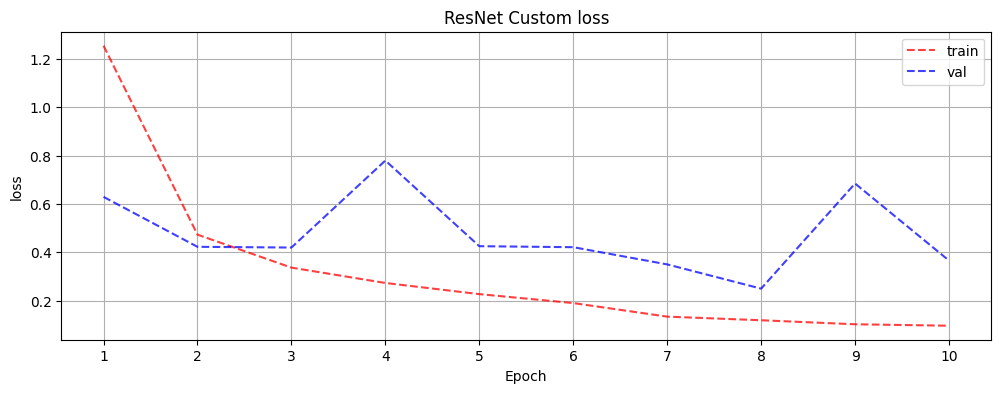

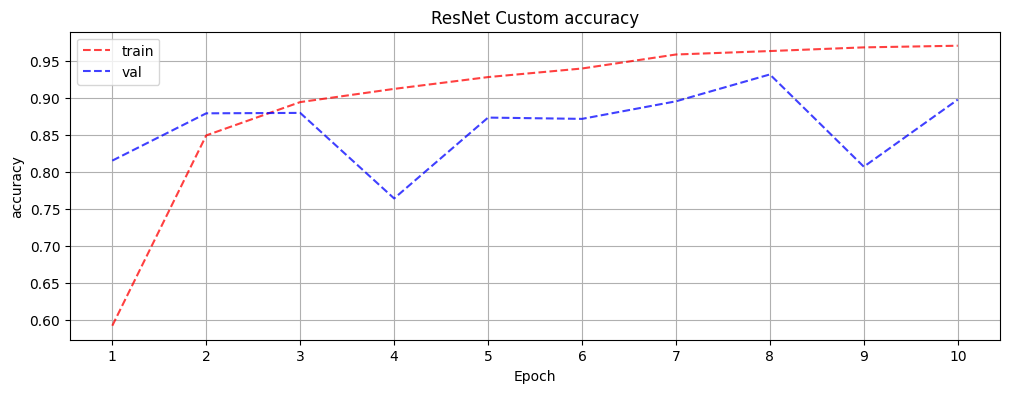

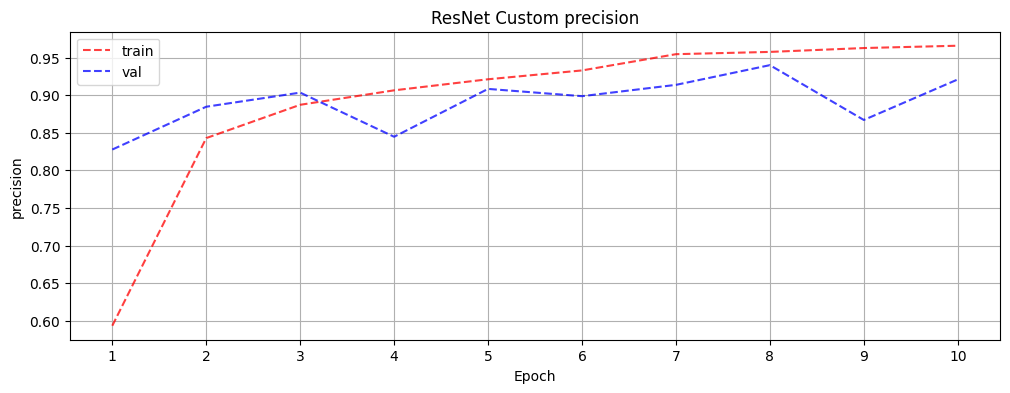

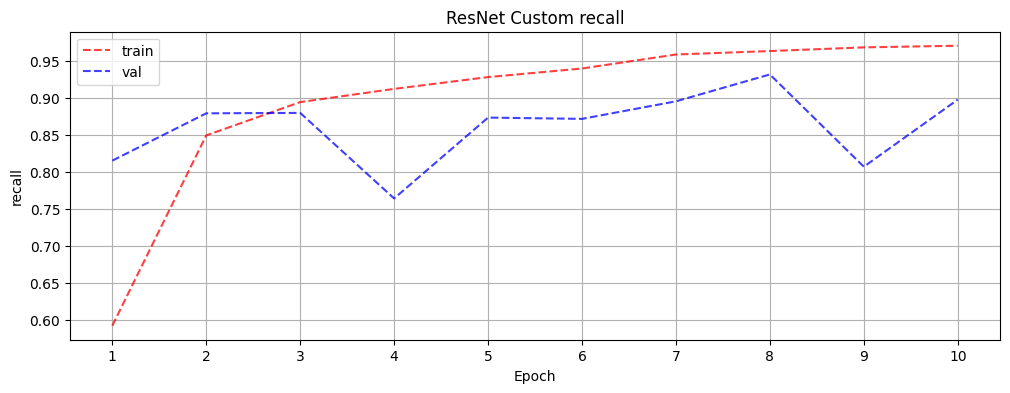

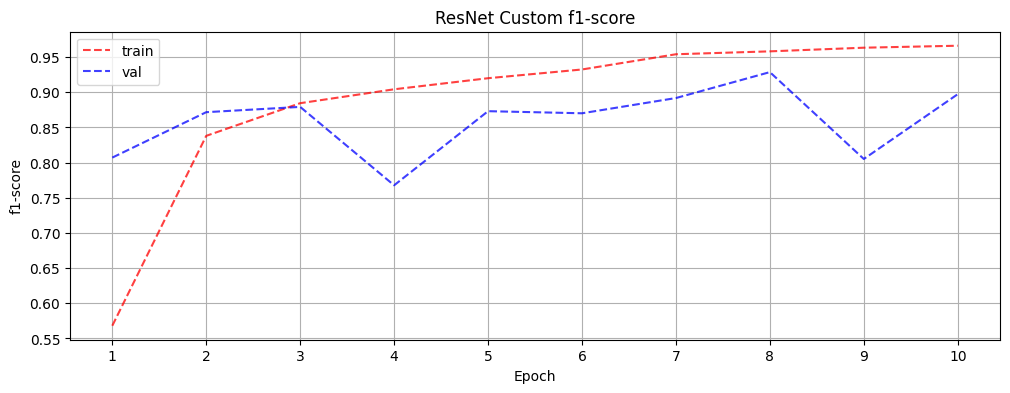

In [15]:
plot_history(history, net_name='ResNet Custom')


# Evaluate neural network 

In [17]:
test_metrics = {
    'accuracy': Accuracy(task='multiclass', num_classes=int(n_classes),
                         average=None).to(device),
    'precision': Precision(task='multiclass', num_classes=int(n_classes),
                           average=None).to(device),
    'recall': Recall(task='multiclass', num_classes=int(n_classes),
                     average=None).to(device),
    'f1-score': F1Score(task='multiclass', num_classes=int(n_classes),
                        average=None).to(device)
}

In [18]:
_, test_metric_values = eval(model, test_dl, prefix='test', criterion=criterion,
                             metrics=test_metrics, device=device)

C:\Users\josep\AppData\Local\Temp\ipykernel_28704\3645691058.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  specgram = torch.load(file_path)


test_loss: 0.369, test_accuracy: 0.895, test_precision: 0.917, test_recall: 0.895, test_f1-score: 0.893

In [19]:
if 'loaded_dataset' in locals() and hasattr(loaded_dataset, 'idx_to_class'):
   idx_to_class_mapping = loaded_dataset.idx_to_class
elif 'test_dataset' in locals() and hasattr(test_dataset, 'idx_to_class'):
   idx_to_class_mapping = test_dataset.idx_to_class
else:
   print("Warning: idx_to_class mapping not found. Using integer labels for confusion matrix.")
   idx_to_class_mapping = {i: str(i) for i in range(int(n_classes))}


# Call the function to generate the confusion matrix plot
generate_confusion_matrix(
    net=model,
    dataloader=test_dl,
    device=device,
    num_classes=int(n_classes),
    idx_to_class=idx_to_class_mapping,
    title="Test Set Confusion Matrix",
    save_path="test_confusion_matrix.png",
    log_to_wandb=False
)

Generating confusion matrix...


Calculating Confusion Matrix:   0%|          | 0/39 [00:00<?, ?it/s]C:\Users\josep\AppData\Local\Temp\ipykernel_28704\3645691058.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe

Confusion matrix plot saved to test_confusion_matrix.png


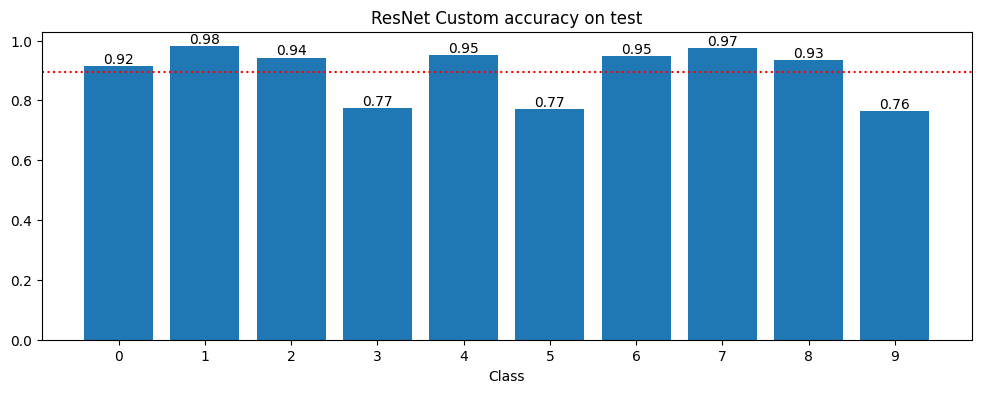

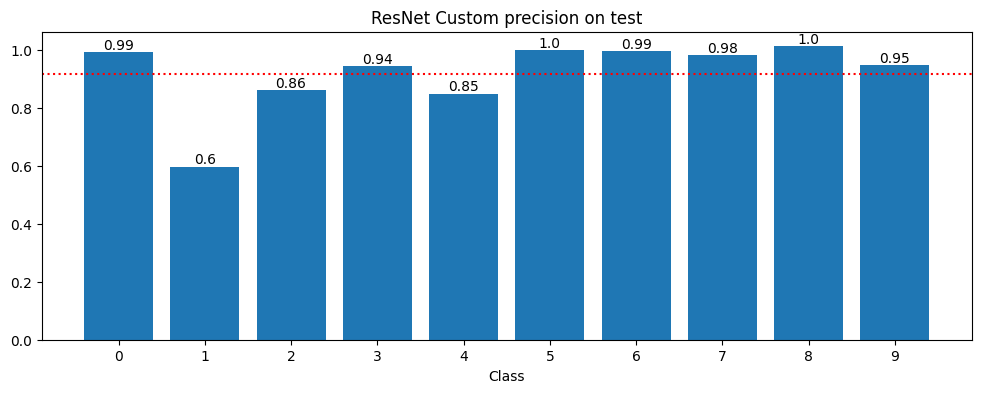

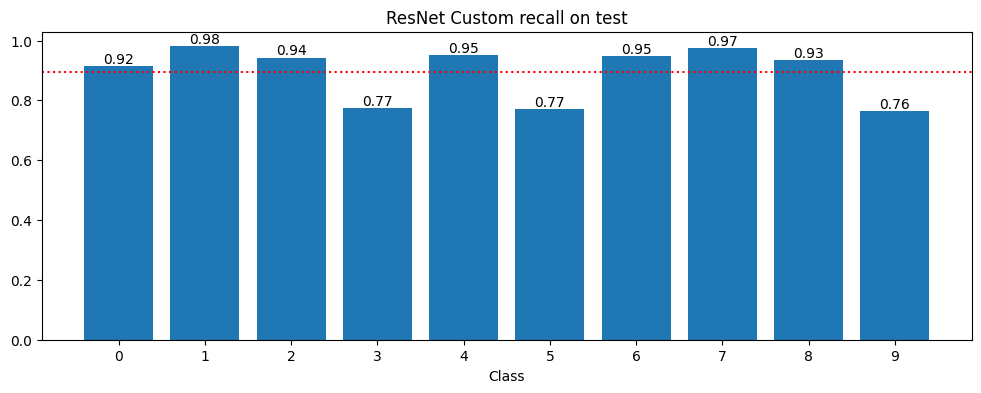

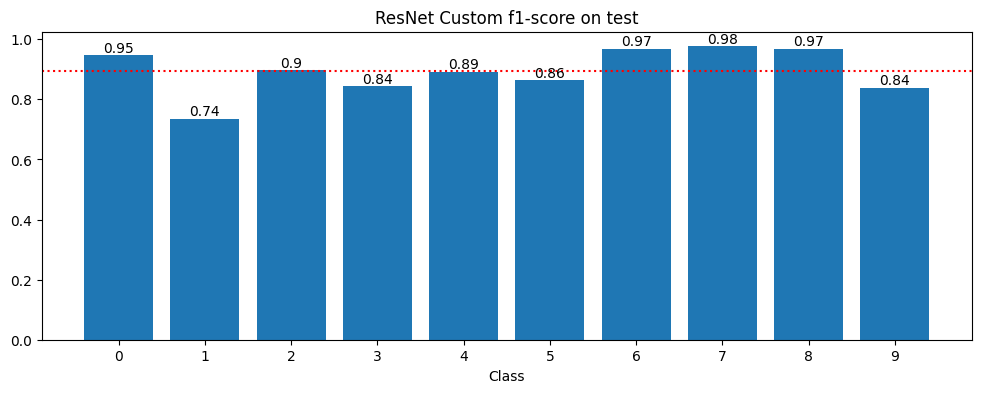

In [20]:
plot_metric_values(test_metric_values, net_name='ResNet Custom')